In [1]:
############################################
# MSDS 442: AI Agent Design and Development
# Spring '25
# Dr. Bader
#
# Assignment 1 - Financial Planning Agent
# 
# Kevin Geidel
############################################

# OBJECTIVE:
#   The following will construct an AI agent using the LangChain & LangGraph frameworks 
#   The agent will act as a Fidelity financial advisor to answer user questions about retirement planning.

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Python native imports
import os, sys, pprint

# Third party library import
from langchain import hub
from langchain_core.prompts import PromptTemplate
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langgraph.prebuilt import tools_condition
from langgraph.graph import END, StateGraph, START
from langchain_core.vectorstores import InMemoryVectorStore
from langgraph.prebuilt import ToolNode
from langchain.document_loaders import WebBaseLoader
os.environ['USER_AGENT'] = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
__import__('pysqlite3')
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from typing import Annotated, Sequence, Literal
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

# Assign experiment-wide variables
model_name = 'gpt-4o-mini'

In [2]:
urls = [
    "https://www.fidelity.com/mutual-funds/why-fidelity-funds",
    "https://www.fidelity.com/mutual-funds/fidelity-funds/overview",
    "https://www.fidelity.com/viewpoints/retirement/how-much-do-i-need-to-retire",
]


# Use WebBaseLoader from LangChain to load the Fidelity.com webpage into a document.
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [3]:
# Lets make vector embeddings for the document in order to store the document in Chroma

# instantiate the transformer
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')

# Store the document in the Chroma vector store
vector_store = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)

In [4]:
# Create a retriever tool that will be used by the AI Agent to verify that the document is relevant to the prompt
retriever = vector_store.as_retriever()

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_fidelity_docs",
    """Search Fidelity Knowledge base in the vector store and return information for:
        - Calculating how much money a person needs to retire
        - Mutual Fund names
        - Types of funds""",
)

tools = [retriever_tool]
tools

[Tool(name='retrieve_fidelity_docs', description='Search Fidelity Knowledge base in the vector store and return information for:\n        - Calculating how much money a person needs to retire\n        - Mutual Fund names\n        - Types of funds', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x7fdf531ffc40>, retriever=VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x7fdf50875550>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x7fdf531ffd80>, retriever=VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x7fdf50875550>, search_kwargs={}), document

In [5]:
# The following classes are used to maintain agent state
# and a agent graph that maps the nodes and edges 

class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [6]:
### Edges

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
#    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a financial advisor answering user question about retirement planning. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes

def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")

    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}

def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [7]:
# Create a graph that will be used to answer the user’s question is relevant or not.

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

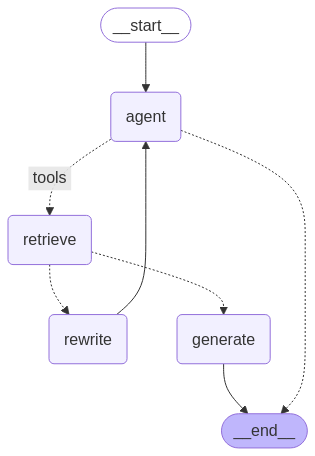

In [8]:
# View the graph
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [9]:
# Assemble the function that will send a user message to the agent

def query_agent(user_message):
    inputs = {
        "messages": [
            ("system", """
                Instructions: 
                        - Check on the user question, query, or prompt content and if it is related to fidelity mutual fund, names of available mututal funds, or retirement 
                            use the tools to retrieve data from your knowledge base in the vector store. 
                        - Provide detailed answer for questions related to retirement or mutual funds based on the knowledge base in the vector store.
                        - For greeting type messaages, respond with message that you can help with questions related to Fidelity mutual funds and retirement planning,
                            otherwsie reply with the message: Sorry this is out of scope. You could use Google to search for this type of content/question"""),
            
            ("user", user_message),

        ]
    }
    for output in graph.stream(inputs):
        for key, value in output.items():
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            pprint.pprint(value, indent=2, width=80, depth=None)
        pprint.pprint("\n---\n")

In [10]:
# requirement #6
query_agent("What are the steps that I should take to determine how much I need to save for retirement planning")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_s9TcVmW4e3qCIlx5q006AViS', 'function': {'arguments': '{"query":"how much money a person needs to retire"}', 'name': 'retrieve_fidelity_docs'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a'}, id='run-4057cae6-ed11-4662-a0bb-b69fb3ba39d1-0', tool_calls=[{'name': 'retrieve_fidelity_docs', 'args': {'query': 'how much money a person needs to retire'}, 'id': 'call_s9TcVmW4e3qCIlx5q006AViS', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content="Consider some hypothetical examples (see graphic). Max plans to delay retirement until age 70, so he will need to have saved 8x his final income to sustain his preretirement lifestyle. Amy wants to 

In [11]:
# requirement #7

# I am not a financial planner but this advice seems sound. The agent recommends a 
# decision tree that can be used to determine a quantitive answer for the question
# "How much do I need to retire?"

In [12]:
# requirement #8

query_agent("What specific steps would a 36 year old take if they have not started retirement savings yet?")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_o8jYiQC3LfmoYAK76FzjVZFG', 'function': {'arguments': '{"query":"steps for retirement savings for a 36 year old"}', 'name': 'retrieve_fidelity_docs'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a'}, id='run-57aa7607-ee89-4cf2-820c-6edf876baae9-0', tool_calls=[{'name': 'retrieve_fidelity_docs', 'args': {'query': 'steps for retirement savings for a 36 year old'}, 'id': 'call_o8jYiQC3LfmoYAK76FzjVZFG', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content="Based on those assumptions, we estimate that saving 10x (times) your preretirement income by age 67, together with other steps, should help ensure that you have enough income to mainta

In [13]:
# This response does not address the specfic question.
# It mentiones there are strategies for catching up but I cannot get the agent
# to elaborate on these.

In [14]:
# requirement 9
query_agent("why my laptop is overheating after 2 hours of usage?")


---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='Sorry this is out of scope. You could use Google to search for this type of content/question.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a'}, id='run-859f2f9b-ba50-4f99-bfcc-ff9c14db8858-0')]}
'\n---\n'


In [ ]:
query_agent("what mutual funds good for cookies?")

In [ ]:
query_agent("what is the current weather conditions in Chicago today?")

In [ ]:
query_agent("Hello there")

In [ ]:
query_agent("what are the names of mutual funds from Fidelity?")

In [ ]:
query_agent("what are the names of mutual funds from Schwab?")

In [15]:
# requirement 10

file_path = os.path.join('src', 'FFFGX.pdf')

# Load the PDF
loader = PyPDFLoader(file_path)

# Store pages
pages = []
async for page in loader.alazy_load():
    pages.append(page)

print(f"Loaded {len(pages)} pages successfully!")

Loaded 6 pages successfully!


In [16]:
print(f"{pages[1].metadata}\n")
print(pages[3].page_content)

{'producer': '', 'creator': 'Quadient~Inspire~16.0.716.7', 'creationdate': '2024-12-21T04:30:27+00:00', 'title': 'MFL_Doc', 'source': 'src/FFFGX.pdf', 'total_pages': 6, 'page': 1, 'page_label': '2'}

Allocation
Glossary Of Terms
Beta: A measure of a portfolio's sensitivity to market movements (as represented by a benchmark index). The benchmark index has a beta of 1.0. A beta of 
more (less) than 1.0 indicates that a fund's historical returns have fluctuated more (less) than the benchmark index. Beta is a more reliable measure of 
volatility when used in combination with a high R2 which indicates a high correlation between the movements in a fund's returns and movements in a 
benchmark index.
Distribution and/or service fee(12b-1) Fees: The 12b-1 fee represents the maximum annual charge deducted from fund assets to pay for distribution and 
marketing costs. Total 12b-1 fees, excluding loads, are capped at 1.00% of average net assets annually. Of this, the distribution and marketing por

In [17]:
vector_store = InMemoryVectorStore.from_documents(pages, OpenAIEmbeddings())
docs = vector_store.similarity_search("What is the fund manager?", k=2)
for doc in docs:
    print(f'Page {doc.metadata["page"]}: {doc.page_content[:1000]}\n')

Page 2: Allocation
Fund Overview (continued)
Additional Disclosures
This description is only intended to provide a brief overview of the mutual fund. Read the fund's 
prospectus for more detailed information about the fund.
Page 3 of 6

Page 3: Allocation
Glossary Of Terms
Beta: A measure of a portfolio's sensitivity to market movements (as represented by a benchmark index). The benchmark index has a beta of 1.0. A beta of 
more (less) than 1.0 indicates that a fund's historical returns have fluctuated more (less) than the benchmark index. Beta is a more reliable measure of 
volatility when used in combination with a high R2 which indicates a high correlation between the movements in a fund's returns and movements in a 
benchmark index.
Distribution and/or service fee(12b-1) Fees: The 12b-1 fee represents the maximum annual charge deducted from fund assets to pay for distribution and 
marketing costs. Total 12b-1 fees, excluding loads, are capped at 1.00% of average net assets annually

In [18]:
import base64
import io

import fitz
from PIL import Image


def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

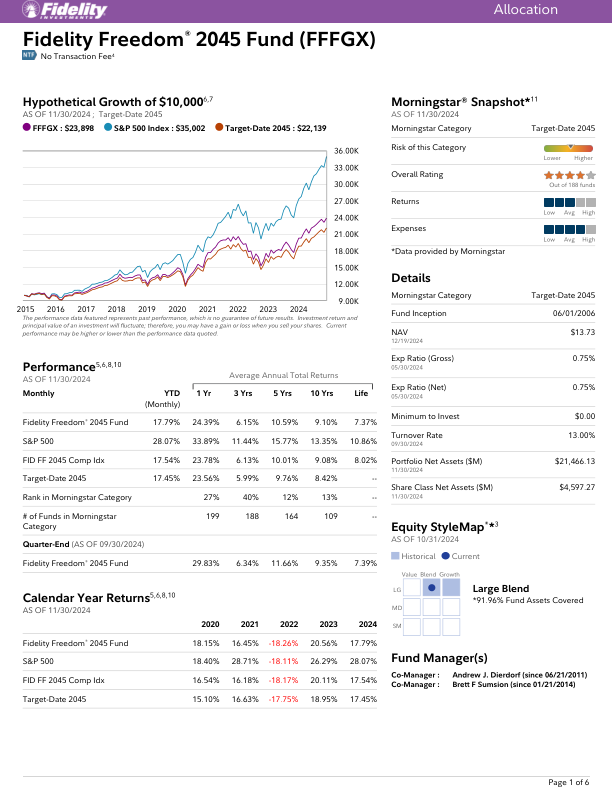

In [20]:
from IPython.display import Image as IPImage
base64_image = pdf_page_to_base64(file_path,1)
display(IPImage(data=base64.b64decode(base64_image)))

In [23]:
# Grab a chat client to test the PDF context
llm = ChatOpenAI(model=model_name)

# lets set up a function to query this LLM in a DRY fashion
def query_llm(query):
    message = HumanMessage(
        content=[
            {"type": "text", "text": query},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
            },
        ],
    )
    response = llm.invoke([message])
    print(response.content)

In [24]:
query_llm("What is the name of this fund?")


The name of the fund is the **Fidelity Freedom® 2045 Fund** (FFFGX).


In [25]:
query_llm("Who is the fund manager?")

The fund managers for the Fidelity Freedom® 2045 Fund (FFFGX) are Andrew J. Dierdoff and Brett F. Smunson.


In [26]:
query_llm("What is the calendar year return for 2022 for this fund and S&P 500")

For the calendar year return in 2022:

- Fidelity Freedom® 2045 Fund (FFFGX): **-18.26%**
- S&P 500: **-18.11%**

These figures indicate the performance of each for that year.


In [27]:
query_llm("What is the Portfolio Net Assets")

The Portfolio Net Assets for the Fidelity Freedom® 2045 Fund (FFFGX) as of 11/30/2024 is **$21,461,836,133**.


In [28]:
query_llm("What is the Morningstar rating for this fund? How many funds used to rate this fund?")

The Morningstar rating for the Fidelity Freedom® 2045 Fund (FFFGX) is **4 stars**. This fund is ranked within the **Target-Date 2045** category. It is evaluated against a total of **198 funds** in that category.
